# Plotting Medical QA experiments

In [13]:
import numpy as np
import pandas as pd
import os
import json
import pickle
from utils import *

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches


In [6]:
'''Load data (mostly for computing population average FDR)'''

## Loading datasets
orig_datasets = {}
suffix = '.jsonl'
dataset_dir = "/home/drewprinster/conformal-safety/data/MedLFQAv2" #"/Users/cherian/Projects/conformal-safety/data/MedLFQAv2"
for path in os.listdir(dataset_dir):
    dataset_name = path[:-len(suffix)]
    if not path.startswith('.'):
        with open(os.path.join(dataset_dir, path), 'r') as fp:
            orig_datasets[dataset_name] = [json.loads(line) for line in fp.readlines()]

## Dictionary where can search using quesiton and get name of original dataset it came from
dataset_lookup = {}
for name, data in orig_datasets.items():
    for dat in data:
        dataset_lookup[dat['Question']] = name

## Getting scores
data_path = "/home/drewprinster/conformal-safety/data" #"/Users/cherian/Projects/conformal-safety/data"
dataset_path = os.path.join(data_path, "medlfqa_dataset.pkl")
freq_path = os.path.join(data_path, "medlfqa_frequencies.npz")
logprob_path = os.path.join(data_path, "medlfqa_logprobs.npz")
selfeval_path = os.path.join(data_path, "medlfqa_selfevals.npz")

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)


## HARD CODED FIX FOR REDUNDANT PROMPT...which has atomic_facts assigned to the wrong redundancy
dataset[1132]['atomic_facts'] = dataset[1048]['atomic_facts']


frequencies = np.load(freq_path)
logprobs = np.load(logprob_path)
selfevals = np.load(selfeval_path)

drop_prompts = []
for k in frequencies:
    if frequencies[k].ndim != 1:
        drop_prompts.append(k)
    elif np.allclose(selfevals[k], -1):
        drop_prompts.append(k)
    elif k not in logprobs:
        drop_prompts.append(k)
    elif remove_specific_leading_chars(k).strip() not in dataset_lookup:
        drop_prompts.append(k)

# drop and match ordering of dataset
dataset = [dat for dat in dataset if dat['prompt'] not in drop_prompts] ## List where each entry is a dictionary with 'prompt', 'response', and 'atomic_facts'
full_dataset = dataset
prompts_to_keep = [dat['prompt'] for dat in dataset] ## List where each entry is the full prompt
names_to_keep = [p.split('about')[-1].strip()[:-1] for p in prompts_to_keep] ## List where each entry is an abbreviated prompt for a name

## Lists where each entry in the list is an array of scores for subclaims
frequencies_arr = [frequencies[p] for p in prompts_to_keep] ## Frequency scoring
selfevals_arr = [selfevals[p] for p in prompts_to_keep] ## Self-evaluation scoring
logprobs_arr = [logprobs[p] for p in prompts_to_keep] ## Log-probability scoring
annotations_arr = [np.asarray([af["is_supported"] for af in dat["atomic_facts"]]) for dat in dataset] ## Oracle (annotation) scoring
ordinal_arr = [np.arange(len(f)) for f in frequencies_arr] ## Ordinal scoring (baseline)


## Record maximum subclaim scores

# If removing data where all subclaims are true (for harder benchmark)
if remove_easy_data:
    indicators_all_subclaims_true = []
    for i in range(len(dataset)):
        indicators_all_subclaims_true.append(bool(min([dataset[i]['atomic_facts'][j]['is_supported'] for j in range(len(dataset[i]['atomic_facts']))])))

    dataset = [d for i, d in enumerate(dataset) if indicators_all_subclaims_true[i]]
    full_dataset = dataset
    prompts_to_keep = [dat['prompt'] for dat in dataset] ## List where each entry is the full prompt
    names_to_keep = [p.split('about')[-1].strip()[:-1] for p in prompts_to_keep] ## List where each entry is an abbreviated prompt for a name

    frequencies_arr = [d for i, d in enumerate(frequencies_arr) if indicators_all_subclaims_true[i]] ## Frequency scoring
    selfevals_arr = [d for i, d in enumerate(selfevals_arr) if indicators_all_subclaims_true[i]] ## Self-evaluation scoring
    logprobs_arr = [d for i, d in enumerate(logprobs_arr) if indicators_all_subclaims_true[i]] ## Log-probability scoring
    annotations_arr = [d for i, d in enumerate(annotations_arr) if indicators_all_subclaims_true[i]] ## Oracle (annotation) scoring
    ordinal_arr = [d for i, d in enumerate(ordinal_arr) if indicators_all_subclaims_true[i]] ## Ordinal scoring (baseline)


print(len(frequencies_arr), len(selfevals_arr), len(dataset), len(annotations_arr))


4805 4805 4805 4805


## Plotting code

['Target Risk Upper Bound', 'Population Avg. Risk', 'GCRC (proposed)', 'LTT (Angelopoulos, et al., 2025)', 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)']
3.144444444444445 4.469444444444445 11.802361111111113 4.913055555555555
['Target Risk Upper Bound', 'Population Avg. Risk', 'GCRC (proposed)', 'LTT (Angelopoulos, et al., 2025)', 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)']
3.144444444444445 4.469444444444445 11.802361111111113 4.913055555555555
['Target Risk Upper Bound', 'Population Avg. Risk', 'GCRC (proposed)', 'LTT (Angelopoulos, et al., 2025)', 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)']
3.144444444444445 4.469444444444445 11.802361111111113 4.913055555555555


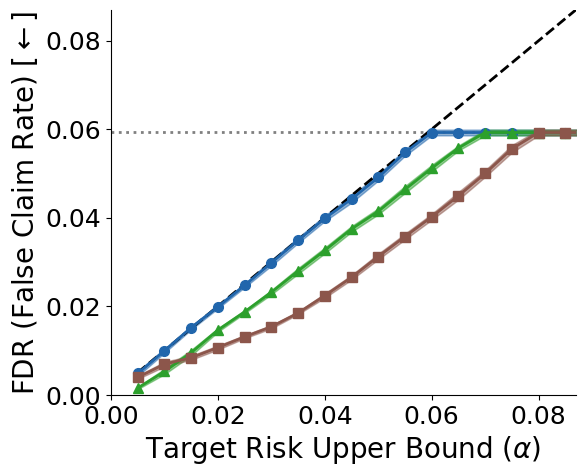

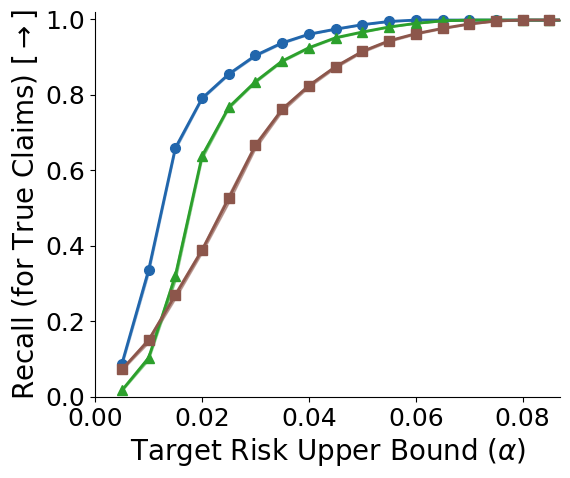

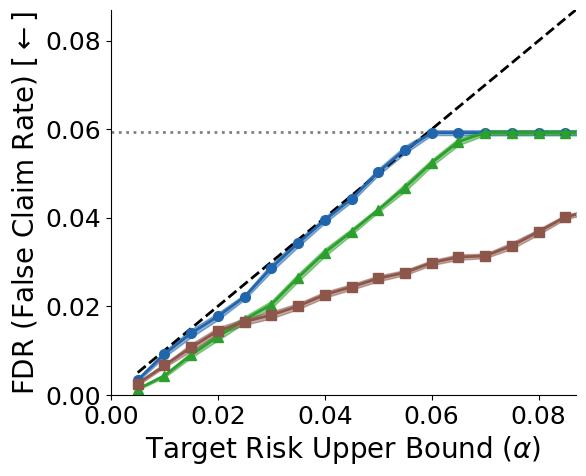

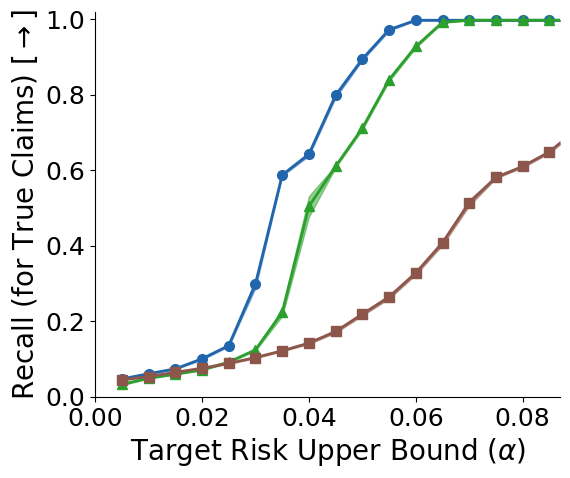

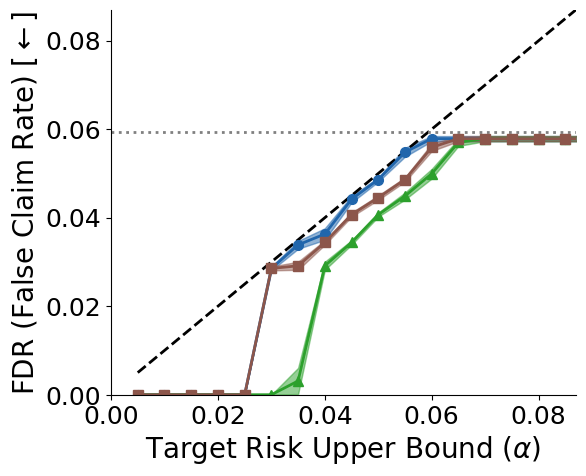

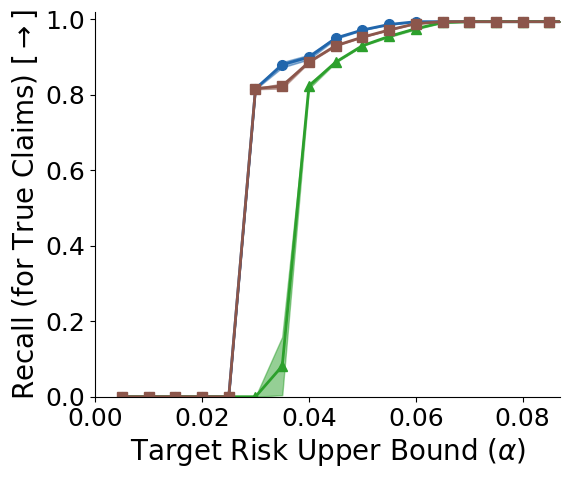

In [15]:
BLUE = '#2166ac'           # β̂ vertical line
TEAL = '#5ab4ac'           # Calibration data (complements blue/red)
RED = '#d73027'            # Test point (conservative/warning)


## Calculate population average FDR for unfactual subclaims
losses = np.zeros(len(annotations_arr))
for i, a in enumerate(annotations_arr):
    losses[i] = np.mean(1-a)
pop_avg_frac_unfactual = losses.mean()


## Plotting from loading
score_names = ["logprobs", "selfevals", "frequency"] #"frequency", "selfevals", "logprobs"
n_trials = 10
loss_name = "loss_factuality_fraction" #"loss_factuality_fraction"
method_names = ["gcrc", "ltt", "monotized_losses_crc"] # "standard_crc", "gcrc", "monotized_losses_crc", "monotized_losses_crc", "ltt",
ngrid = 200

for s_i, score_name in enumerate(score_names): #frequencies_arr, selfevals_arr, 

    results_df = pd.read_csv(f'/home/drewprinster/conformal-safety/notebooks/{loss_name}Loss_{score_name}Scoring_{n_trials}trials_{ngrid}ngrid_v2.csv')

    # display(results_df)
    # print(results_df.columns)
    
    method_name_map = {'gcrc' : 'GCRC (proposed)', 
                       'monotized_losses_crc' : 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)',
                       'standard_crc' : 'standard CRC (Angelopoulos, et al., 2024)',
                       'ltt' : 'LTT (Angelopoulos, et al., 2025)'}
    
    colors_dict = {'gcrc' : BLUE, 'monotized_losses_crc' : 'C5', 'ltt' : 'C2', 'standard_crc' : 'C1'}
    markers_dict = {'gcrc' : 'o', 'monotized_losses_crc' : 's', 'ltt' : '^', 'standard_crc' : 'X'}

    axlabelsize=20
    ticklabelsize=18
    plt.rc("axes.spines", top=False, right=False)
    markersize=7
    linewidth=2

                   
    for metric in ['risk', 'claims']:
        fig, ax = plt.subplots(figsize=(6, 5))
        alphas = results_df['alphas']
        
        # metric_dict = eval(f'{metric}_dict')
        if metric == 'risk':
            ax.plot(alphas, alphas, linestyle='--', color='black', label='Target Risk Upper Bound', linewidth=linewidth)
            ax.axhline(pop_avg_frac_unfactual, color='gray', label='Population Avg. Risk', linestyle=':', linewidth=linewidth)
            ax.set_ylabel(r'FDR (False Claim Rate) [$\leftarrow$]', fontsize=axlabelsize)
        else:
            ax.set_ylabel(r'Recall (for True Claims) [$\rightarrow$]', fontsize=axlabelsize)
            
        for m, method_name in enumerate(method_names):
            
            metric_mean = results_df[f'{method_name}_{metric}_mean']
            metric_std = results_df[f'{method_name}_{metric}_std']

            
            ax.fill_between(alphas, metric_mean - metric_std / np.sqrt(n_trials), metric_mean + metric_std / np.sqrt(n_trials), color=colors_dict[method_name], alpha = 0.5)
            ax.plot(alphas, metric_mean,  marker=markers_dict[method_name], label = method_name_map[method_name], color=colors_dict[method_name], markersize=markersize,linewidth=linewidth)
        
        ax.tick_params(axis='both', which='major', labelsize=ticklabelsize)
        ax.set_xlabel(r'Target Risk Upper Bound ($\alpha$)', fontsize=axlabelsize)
        ax.set_xlim([0.0, 0.087])
        if metric == 'risk':
            ax.set_ylim([0.0, 0.087])
        else:
            ax.set_ylim([0.0, 1.02])
        fig.savefig(f'{loss_name}Loss_{score_names[s_i]}Scoring_{metric}_{n_trials}trials_{ngrid}ngrid.pdf', bbox_inches='tight', dpi=300)

        

        if metric == 'risk':
            ## Save legend
            handles, labels = ax.get_legend_handles_labels()
            print(labels)
            leg1 = ax.legend(handles[0:3], labels[0:3], loc='lower left', bbox_to_anchor=(0.5, 1.05), ncols=3, frameon=False)
            ax.add_artist(leg1)
            legend_extent1 = leg1.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
            leg1.set_in_layout(False)
            # fig.savefig(f'legend1_{score_name}_{metric}_v2.pdf', bbox_inches=legend_extent1, dpi=300)
        
            leg2 = ax.legend(handles[3:], labels[3:], loc='lower left', bbox_to_anchor=(0.5, 1.0), ncols=2, frameon=False)
            # ax.add_artist(leg2)
            # leg1.set_in_layout(False)
            leg2.set_in_layout(False)
            legend_extent2 = leg2.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
            union_bbox = mtransforms.Bbox.union([legend_extent1, legend_extent2])
            print(union_bbox.x0, union_bbox.y0, union_bbox.x1, union_bbox.y1)

            # Create a Rectangle patch
            # Set `facecolor='none'` to make the inside transparent
            # Set `edgecolor` and `linewidth` to customize the border
            # rect = patches.Rectangle((union_bbox.x0, union_bbox.y0), union_bbox.x1, union_bbox.y1, linewidth=2, edgecolor='black', facecolor='none')
            
            # Add the patch to the axes
            # ax.add_patch(rect)

            fig.savefig(f'legend_{score_name}_{metric}.pdf', bbox_inches=union_bbox, dpi=300)

        fig.show()

    # results_df.to_csv(f'{loss_name}Loss_{score_names[s_i]}Scoring_{metric}_{n_trials}trials_notebook.csv')

